In [84]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
#from tensorflow.keras.layers import Conv2D, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import random
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from fancyimpute import IterativeImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import precision_score, f1_score, recall_score, auc, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from tensorflow.python.framework import ops
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.preprocessing import StandardScaler
ops.reset_default_graph()
from xgboost import XGBClassifier
random.seed(271828)
np.random.seed(271828)
#import tensorflow as tf
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
tf.random.set_seed(271828)

In [30]:

def PCL_calculator(df):

    symptomatic_cutoff = 2

    intrusion = ['q6.1_INTRU', 'q6.2_DREAM', 'q6.3_FLASH', 'q6.4_UPSET', 'q6.5_PHYS']
    avoidance = ['q6.6_AVTHT', 'q6.7_AVSIT', 'q6.8_AMNES', 'q6.9_DISINT', 'q6.10_DTACH',
                 'q6.11_NUMB', 'q6.12_FUTRE']
    tred = ['q6.1_INTRU', 'q6.2_DREAM', 'q6.3_FLASH']
    only_avoidance = ['q6.6_AVTHT', 'q6.7_AVSIT', 'q6.8_AMNES']

    hypertension = ['q6.13_SLEEP', 'q6.14_ANGER', 'q6.15_CONC', 'q6.16_HYPER', 'q6.17_STRTL']

    depression = ['q6.9_DISINT', 'q6.10_DTACH', 'q6.11_NUMB', 'q6.12_FUTRE']

    df[intrusion + avoidance + hypertension].fillna(df[intrusion + avoidance + hypertension].mean(axis=1))
    intrusion_cuoff = 1
    avoidance_cuoff = 3
    hypertension_cuoff = 2
    only_avoidance_cutoff = 1
    depression_cutoff = 2
    tred_cutoff = 1

    df['sum'] = (df[intrusion + avoidance + hypertension]).sum(axis=1)

    df['intrusion'] = (df[intrusion] > symptomatic_cutoff).sum(axis=1)
    df['intrusion_cutoff'] = (df['intrusion'] >= intrusion_cuoff).astype(int)

    df['avoidance'] = (df[avoidance] > symptomatic_cutoff).sum(axis=1)
    df['avoidance_cutoff'] = (df['avoidance'] >= avoidance_cuoff).astype(int)

    df['depression'] = (df[depression] > symptomatic_cutoff).sum(axis=1)
    df['depression_cutoff'] = df['depression'] >= depression_cutoff

    df['hypertention'] = (df[hypertension] > symptomatic_cutoff).sum(axis=1)
    df['hypertention_cutoff'] = (df['hypertention'] >= hypertension_cuoff).astype(int)

    df['tred'] = (df[tred] > symptomatic_cutoff).sum(axis=1)
    df['tred_cutoff'] = df['tred'] >= tred_cutoff

    df['only_avoidance'] = (df[only_avoidance] > symptomatic_cutoff).sum(axis=1)
    df['only_avoidance_cutoff'] = df['only_avoidance'] >= only_avoidance_cutoff

    df['regression_cutoff_33'] = df['sum'] >= 33
    df['regression_cutoff_50'] = df['sum'] >= 50
    df['diagnosis'] = ((df['hypertention_cutoff']) & (df['avoidance_cutoff']) & (df['intrusion_cutoff']) & (df['sum'] >= 50))

    return df



In [31]:
path = "C:\‏‏PycharmProjects\PTSD\Data\PTSD.xlsx"
df = pd.read_excel(path)
#combine with specifics of answers
df_pcl2 = pd.read_excel("C:\‏‏PycharmProjects\PTSD\Data\questionnaire6PCL2.xlsx")
df_pcl1 = pd.read_excel("C:\‏‏PycharmProjects\PTSD\Data\questionnaire6PCL1.xlsx")
df = df.merge(df_pcl1, on="ID", how='outer')
df = df.merge(df_pcl2, suffixes=('_pcl1', '_pcl2'), on="ID", how='outer')

df_pcl3 = pd.read_excel("C:\‏‏PycharmProjects\PTSD\Data\questionnaire6PCL3.xlsx")
df_pcl3 = PCL_calculator(df_pcl3)
df = df.merge(df_pcl3.drop(['PCL3_Strict', 'pcl3', 'PCL3_Broad'], axis=1), on="ID", how='outer')
# rmoving missing Y's
df = df[~df['PCL_Strict3'].isna()]

## features 

In [32]:

features = ["age", "highschool_diploma", "dyslexia", "ADHD", "T1Acc1t", "T1Acc1n", "T1bias", "phq1", "lot1",
                "trait1",
                "state1", "PCL1", "PCL_Broad1", "PCL_Strict1", "phq2", "lot2", "trait2", "state2", "PCL2", "PCL_Broad2",
                "PCL_Strict2", "cd_risc1", "active_coping1", "planning1", "positive_reframing1", "acceptance1",
                "humor1",
                "religion1", "emotional_support1", "instrumental_support1", "self_distraction1", "denial1",
                "venting1", "substance_use1", "behavioral_disengagement1", "self_blame1", "active_coping2", "planning2",
                "positive_reframing2", "acceptance2", "humor2", "religion2", "emotional_support2",
                "instrumental_support2",
                "self_distraction2", "denial2", "venting2", "substance_use2", "behavioral_disengagement2",
                "self_blame2",
                "trauma_history8_1", "HML_5HTT", "HL_MAOA", "HML_NPY", "COMT_Hap1_recode",
                "COMT_Hap2_recode", "COMT_Hap1_LvsMH", "HML_FKBP5", 'q6.1_INTRU_pcl1', 
                'q6.2_DREAM_pcl1', 'q6.3_FLASH_pcl1', 'q6.4_UPSET_pcl1',
                  'q6.5_PHYS_pcl1', 'q6.6_AVTHT_pcl1', 'q6.7_AVSIT_pcl1', 'q6.8_AMNES_pcl1', 'q6.9_DISINT_pcl1',
                  'q6.10_DTACH_pcl1', 'q6.11_NUMB_pcl1', 'q6.12_FUTRE_pcl1', 'q6.13_SLEEP_pcl1',
                  'q6.14_ANGER_pcl1', 'q6.15_CONC_pcl1', 'q6.16_HYPER_pcl1', 'q6.17_STRTL_pcl1',
                  'q6.1_INTRU_pcl2', 'q6.2_DREAM_pcl2', 'q6.3_FLASH_pcl2', 'q6.4_UPSET_pcl2',
                  'q6.5_PHYS_pcl2', 'q6.6_AVTHT_pcl2', 'q6.7_AVSIT_pcl2', 'q6.8_AMNES_pcl2', 'q6.9_DISINT_pcl2',
                  'q6.10_DTACH_pcl2', 'q6.11_NUMB_pcl2', 'q6.12_FUTRE_pcl2', 'q6.13_SLEEP_pcl2',
                  'q6.14_ANGER_pcl2', 'q6.15_CONC_pcl2', 'q6.16_HYPER_pcl2', 'q6.17_STRTL_pcl2']

In [33]:
discrete_features = ["age", "highschool_diploma", "dyslexia", "ADHD", "phq1", "lot1",
                    "trait1", "state1", "PCL1", "PCL_Broad1", "PCL_Strict1", "phq2", "lot2",
                    "trait2", "state2", "PCL2", "PCL_Broad2", "PCL_Strict2", "cd_risc1", "active_coping1",
                    "planning1", "positive_reframing1", "acceptance1", "humor1", "religion1",
                    "emotional_support1", "instrumental_support1", "self_distraction1", "denial1",
                    "venting1", "substance_use1", "behavioral_disengagement1", "self_blame1", "active_coping2",
                    "planning2", "positive_reframing2", "acceptance2", "humor2", "religion2", "emotional_support2",
                    "instrumental_support2", "self_distraction2", "denial2", "venting2", "substance_use2",
                    "behavioral_disengagement2", "self_blame2", "trauma_history8_1",
                    'q6.1_INTRU_pcl1', 'q6.2_DREAM_pcl1', 'q6.3_FLASH_pcl1', 'q6.4_UPSET_pcl1',
                    'q6.5_PHYS_pcl1', 'q6.6_AVTHT_pcl1', 'q6.7_AVSIT_pcl1', 'q6.8_AMNES_pcl1', 'q6.9_DISINT_pcl1',
                    'q6.10_DTACH_pcl1', 'q6.11_NUMB_pcl1', 'q6.12_FUTRE_pcl1', 'q6.13_SLEEP_pcl1',
                    'q6.14_ANGER_pcl1', 'q6.15_CONC_pcl1', 'q6.16_HYPER_pcl1', 'q6.17_STRTL_pcl1',
                    'q6.1_INTRU_pcl2', 'q6.2_DREAM_pcl2', 'q6.3_FLASH_pcl2', 'q6.4_UPSET_pcl2',
                    'q6.5_PHYS_pcl2', 'q6.6_AVTHT_pcl2', 'q6.7_AVSIT_pcl2', 'q6.8_AMNES_pcl2', 'q6.9_DISINT_pcl2',
                    'q6.10_DTACH_pcl2', 'q6.11_NUMB_pcl2', 'q6.12_FUTRE_pcl2', 'q6.13_SLEEP_pcl2',
                    'q6.14_ANGER_pcl2', 'q6.15_CONC_pcl2', 'q6.16_HYPER_pcl2', 'q6.17_STRTL_pcl2',
                    'intrusion_cutoff', 'avoidance_cutoff', 'hypertention_cutoff']

In [34]:
genome_features = ["HML_5HTT", "HL_MAOA", "HML_NPY", "COMT_Hap1_recode",
                "COMT_Hap2_recode", "COMT_Hap1_LvsMH", "HML_FKBP5"]
continuous_features = ["T1Acc1t", "T1Acc1n", "T1bias"]

## fill the missing values

In [35]:
df[genome_features] = df[genome_features].fillna(0)
df[continuous_features] = df[continuous_features].fillna(df[continuous_features].mean())
df[discrete_features] = df[discrete_features].fillna(df[discrete_features].median())


## cut off the test set

In [36]:
X, X_out, Y, y_out = train_test_split(df[features], df[['intrusion_cutoff', 'avoidance_cutoff',
                                                        'hypertention_cutoff', 'PCL_Strict3']],
                                      test_size=0.25, random_state=271828, stratify=df['PCL_Strict3'])

## the Model

In [42]:
model = Pipeline(steps=[
    ('anova', SelectKBest()),
        ('clf',  RandomForestClassifier(random_state=271828))])

grid_params = [{'anova__k':[65, 35, 50, 92],'clf__n_estimators': [100], 
                'clf__max_depth': [5],
               'clf__min_samples_split': [2],
                'clf__class_weight':[{1:3, 0:1}, {1:5, 0:1}, {1:1, 0:1}]}]


## intrusion

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, Y['intrusion_cutoff'], test_size=0.25, stratify=Y['PCL_Strict3'], random_state=271828)
cv = StratifiedKFold(10, random_state=271828)  

In [44]:
intrusion_gs = GridSearchCV(model, grid_params,  scoring="roc_auc", cv=cv)
intrusion_gs.fit(X_train, y_train)
print("roc_auc", intrusion_gs.best_score_,"\nparams = ", intrusion_gs.best_params_)

roc_auc 0.7709319556826889 
params =  {'anova__k': 35, 'clf__class_weight': {1: 5, 0: 1}, 'clf__max_depth': 5, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}


In [45]:
scores = cross_val_score(intrusion_gs.best_estimator_, X_train, y_train, scoring="precision", cv=cv)
print("precision\n", scores,"\nmean = ", scores.mean())


precision
 [0.47368421 0.4        0.46666667 0.58333333 0.33333333 0.42857143
 0.5        0.72727273 0.4375     0.54545455] 
mean =  0.48958162451583503


## avoidance cutoff

In [46]:
model = Pipeline(steps=[
    ('anova', SelectKBest()),
    ('clf',  RandomForestClassifier(random_state=271828))])

grid_params = [{'anova__k':[15], 'clf__n_estimators': [100],
                'clf__max_depth': [7, 5],
               'clf__min_samples_split': [4],
                'clf__max_features':[0.25,0.15,0.35, 'auto'], 
                'clf__class_weight':[{1:5, 0:1}, {1:7, 0:1}]}]


In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, Y['avoidance_cutoff'], test_size=0.25, stratify=Y['PCL_Strict3'], random_state=271828)
cv = StratifiedKFold(10, random_state=271828)  

In [48]:
avoidance_gs = GridSearchCV(model, grid_params,  scoring="roc_auc", cv=cv)
avoidance_gs.fit(X_train, y_train)
print("roc_auc", avoidance_gs.best_score_,"\nparams = ", avoidance_gs.best_params_)

roc_auc 0.7815139815139814 
params =  {'anova__k': 15, 'clf__class_weight': {1: 7, 0: 1}, 'clf__max_depth': 5, 'clf__max_features': 0.25, 'clf__min_samples_split': 4, 'clf__n_estimators': 100}


In [49]:
scores = cross_val_score(avoidance_gs.best_estimator_, X_train, y_train, scoring="precision", cv=cv)
print("precision\n", scores,"\nmean = ", scores.mean())


precision
 [0.57142857 0.22222222 0.44444444 0.6        0.375      0.
 0.4        0.14285714 0.33333333 0.57142857] 
mean =  0.36607142857142855


## hypertension cutoff

In [50]:
model = Pipeline(steps=[
    
    ('anova', SelectKBest()),
    ('clf',  RandomForestClassifier(random_state=271828))])

grid_params = [{'anova__k':[50, 60, 70], 'clf__n_estimators': [150],  'clf__max_depth': [4],
               'clf__min_samples_split': [2,3],'clf__max_features':[0.25,0.15,0.35, 'auto'],
                'clf__class_weight':[{1:1, 0:5}, {1:1, 0:1}, {1:1, 0:10}]}]


In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, Y['hypertention_cutoff'], test_size=0.25, stratify=Y['PCL_Strict3'], random_state=271828)
cv = StratifiedKFold(10, random_state=271828)  

In [52]:
hypertention_gs = GridSearchCV(model, grid_params,  scoring="roc_auc", cv=cv)
hypertention_gs.fit(X_train, y_train)
print("roc_auc", hypertention_gs.best_score_,"\nparams = ", hypertention_gs.best_params_)

roc_auc 0.7814291564291563 
params =  {'anova__k': 60, 'clf__class_weight': {1: 1, 0: 5}, 'clf__max_depth': 4, 'clf__max_features': 0.25, 'clf__min_samples_split': 2, 'clf__n_estimators': 150}


In [53]:
scores = cross_val_score(hypertention_gs.best_estimator_, X_train, y_train, scoring="precision", cv=cv)
print("precision\n", scores,"\nmean = ", scores.mean())


precision
 [0.66666667 0.66666667 0.         1.         0.4        1.
 0.         0.5        1.         0.75      ] 
mean =  0.5983333333333333


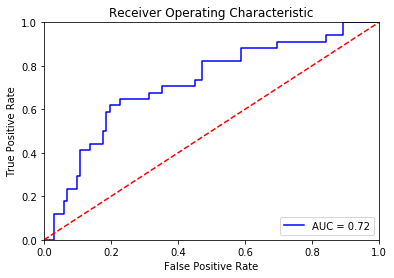

In [54]:
from sklearn.metrics import roc_curve, auc

y_pred_intrusion = intrusion_gs.best_estimator_.predict_proba(X_test)
y_pred_avoidance = avoidance_gs.best_estimator_.predict_proba(X_test)
y_pred_hypertension = hypertention_gs.best_estimator_.predict_proba(X_test)
preds = y_pred_intrusion[:,1] * y_pred_avoidance[:,1] * y_pred_hypertension[:,1] 
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

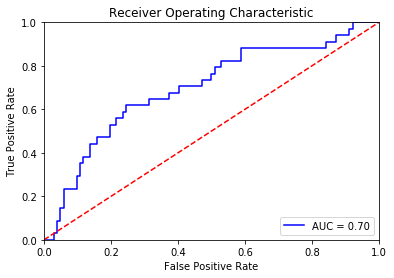

In [55]:
from sklearn.metrics import roc_curve, auc

y_pred_intrusion = intrusion_gs.best_estimator_.predict_proba(X_test)
y_pred_avoidance = avoidance_gs.best_estimator_.predict_proba(X_test)
y_pred_hypertension = hypertention_gs.best_estimator_.predict_proba(X_test)
preds = y_pred_intrusion[:,1] *  y_pred_hypertension[:,1] 
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

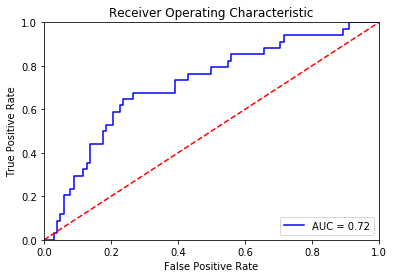

In [57]:
from sklearn.metrics import roc_curve, auc

y_pred_intrusion = intrusion_gs.best_estimator_.predict_proba(X_test)
y_pred_avoidance = avoidance_gs.best_estimator_.predict_proba(X_test)
y_pred_hypertension = hypertention_gs.best_estimator_.predict_proba(X_test)
preds = y_pred_avoidance[:,1] * y_pred_hypertension[:,1] 
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

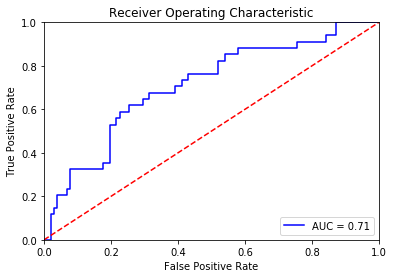

In [62]:
from sklearn.metrics import roc_curve, auc

y_pred_intrusion = intrusion_gs.best_estimator_.predict_proba(X_test)
y_pred_avoidance = avoidance_gs.best_estimator_.predict_proba(X_test)
y_pred_hypertension = hypertention_gs.best_estimator_.predict_proba(X_test)
preds = y_pred_intrusion[:,1] * y_pred_avoidance[:,1] 
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

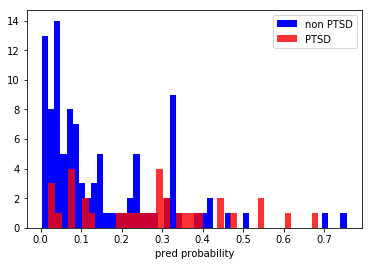

In [63]:
plt.hist(preds[y_test==0], bins=50, color="b", label="non PTSD")
plt.hist(preds[y_test==1], bins=40, alpha=0.8, color="r", label="PTSD")
plt.xlabel('pred probability')
plt.legend();

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, stratify=Y['PCL_Strict3'], random_state=271828)

In [99]:
cv = StratifiedKFold(10, random_state=271828)
scores_f = []
scores_p = []
scores_r = []
scores_auc = []


for train, test in cv.split(X_train, y_train['PCL_Strict3']):
    X_train_cv = X_train.iloc[train]
    y_train_cv = y_train.iloc[train]

    t = [y_train_cv, y_train_cv['intrusion_cutoff'], y_train_cv['avoidance_cutoff'],y_train_cv['hypertention_cutoff']]
    
    y_train_cv.drop(['intrusion_cutoff', 'avoidance_cutoff', 'hypertention_cutoff'], axis=1, inplace=True)
    
    y_pred_intrusion = intrusion_gs.best_estimator_.fit(X_train_cv, t[1]).predict_proba(X_train.iloc[test])
    y_pred_avoidance = avoidance_gs.best_estimator_.fit(X_train_cv, t[2]).predict_proba(X_train.iloc[test])
    y_pred_hypertension = hypertention_gs.best_estimator_.fit(X_train_cv, t[3]).predict_proba(X_train.iloc[test])

    y_pred = (y_pred_intrusion[:, 1] >= 0.5) & (y_pred_avoidance[:, 1] >= 0.5) & (y_pred_hypertension[:, 1] >= 0.5)

    scores_f.append(f1_score(y_train['PCL_Strict3'].iloc[test], y_pred))
    scores_p.append(precision_score(y_train['PCL_Strict3'].iloc[test], y_pred))
    scores_r.append(recall_score(y_train['PCL_Strict3'].iloc[test], y_pred))
    scores_auc.append(roc_auc_score(y_train['PCL_Strict3'].iloc[test], y_pred))

In [100]:
print(scores_f)
print(np.mean(scores_p))
print(scores_r)
print(scores_auc)
print(np.mean(scores_auc))

[0.6666666666666666, 0.4, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, 0.5, 0.28571428571428575, 0.5]
0.26999999999999996
[0.6666666666666666, 0.3333333333333333, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.5]
[0.8205128205128204, 0.6538461538461537, 0.6403508771929824, 0.5, 0.5, 0.4736842105263158, 0.4868421052631579, 0.7368421052631579, 0.6973684210526315, 0.7368421052631579]
0.6246288798920376


## predict holdout set

In [25]:
cv = StratifiedKFold(10, random_state=271828)  
y_pred_intrusion = intrusion_gs.best_estimator_.predict_proba(X_test)
y_pred_avoidance = avoidance_gs.best_estimator_.predict_proba(X_test)
y_pred_hypertension = hypertention_gs.best_estimator_.predict_proba(X_test)

y_pred = ((y_pred_intrusion[:, 1]>0.25) & (y_pred_avoidance[:, 1]>0.25)& (y_pred_hypertension[:, 1]>0.25))
print("f1 precision_score =", precision_score(y_test, y_pred), "from ", sum(y_pred))


f1 precision_score = 0.5 from  14


In [26]:
y_pred = ((y_pred_intrusion[:, 1]>0.5) & (y_pred_avoidance[:, 1]>0.5)& (y_pred_hypertension[:, 1]>0.5))
print("auc precision_score =", precision_score(y_test, y_pred), "from ", sum(y_pred))


auc precision_score = 0.25 from  4


In [27]:
y_pred = ((y_pred_intrusion[:, 1]>0.15) & (y_pred_avoidance[:, 1]>0.15)& (y_pred_hypertension[:, 1]>0.15))
print("auc precision_score =", precision_score(y_test, y_pred), "from ", sum(y_pred))


auc precision_score = 0.45454545454545453 from  22


In [28]:
y_pred = ((y_pred_intrusion[:, 1]>0.65) & (y_pred_avoidance[:, 1]>0.65)& (y_pred_hypertension[:, 1]>0.65))
print("auc precision_score =", precision_score(y_test, y_pred), "from ", sum(y_pred))


auc precision_score = 0.0 from  2
